# Pokemon Data Analysis #

The following notebook aims to address these questions:

1.  What is the best Pokemon type I could use to fight my opponent's Pokemon?

2.  How did the Pokemon designers go about distributing the character's abilities to make the game engaging (perhaps even addicting)?

3. Can we predict a legendary pokemon with minimal information? (Bonus Q - explored at the very end)

## 1. Install Libraries ##

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable

from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D
from pySankey.sankey import sankey

In [2]:
#Optional: hide warnings
import warnings
warnings.simplefilter('ignore')

In [3]:
#Recommended: set DPI globally for all figures
plt.rcParams['figure.dpi'] = 100

## 2. Data Validation ##

In [4]:
#Load data
data = pd.read_csv('./pokemon.csv')

data

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,['Beast Boost'],0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,...,NaN,797,107,101,61,steel,flying,999.9,7,1
797,['Beast Boost'],1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,...,NaN,798,59,31,109,grass,steel,0.1,7,1
798,['Beast Boost'],2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,...,NaN,799,97,53,43,dark,dragon,888.0,7,1
799,['Prism Armor'],2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,...,NaN,800,127,89,79,psychic,NaN,230.0,7,1


### Variables ###

In [5]:
data.columns

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')

- There are both qualitative variables (type 1, type 2, name, abilities) and quantitative variables (HP, base_total, attack, defense, speed, weight…)

Look at columns:

In [6]:
len(set(data['abilities']))

482

Too many combinations. Removal recommended.

In [7]:
len(set(data['classfication']))

588

Classification also has too many variable options for meaningful data analysis.

#### We have now removed columns that are not statistically relevant: abilities, classification, japanese_name, name. ####

Remaining Columns: 

- against_x** (see below)

- attack
- base_egg_steps
- base_happiness
- base_total
- capture_rate
- defense
- experience_growth
- height_m
- hp
- percentage_male
- pokedex_number
- sp_attack
- sp_defense
- speed
- type1
- type2
- weight_kg
- generation
- is_legendary


against_x:

- against_bug
- against_dark
- against_dragon
- against_electric
- against_fairy
- against_fight
- against_fire
- against_flying
- against_ghost
- against_grass
- against_ground
- against_ice
- against_normal
- against_poison
- against_psychic
- against_rock
- against_steel
- against_water

In [8]:
number_of_blanks = data['type2'].isnull().sum()

In [9]:
percentage_of_blanks = number_of_blanks / len(data) * 100

In [10]:
round(percentage_of_blanks, 3)

47.94

Type 2 has too many blanks, so we will opt for using Type 1 instead and dropping Type 2.

Of our remaining columns, the ones that are left AND are also numerical are:
Remaining Columns: 

- attack
- base_egg_steps
- base_happiness
- base_total
- capture_rate
- defense
- experience_growth
- height_m
- hp
- percentage_male
- pokedex_number
- sp_attack
- sp_defense
- speed
- weight_kg
- generation
- is_legendary


Our investigation can take us down a quantitaive path... or a qualitative path. 

Let's explore our remaining variables and see if they are continuous or categorical variables:

In [11]:
#Generation - which generation of pokemon?
set(data['generation'])

{1, 2, 3, 4, 5, 6, 7}

In [12]:
#Is Legendary? - is the pokemon legendary or not?
set(data['is_legendary'])

{0, 1}

Technically, generation and legendary are categories. (Discrete, non-continuous). 

We will use still these two variables to create a new dataframe of all columns with numerical data, so they are not to be dismissed. 

In fact, they end up being very important later on.

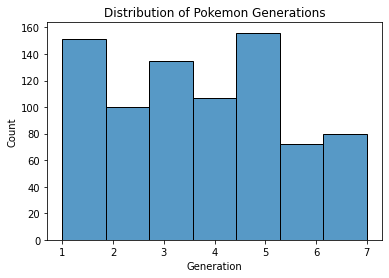

In [13]:
#Histogram of Generations, bins = # of generations
sns.histplot(data['generation'], bins=7)

plt.title('Distribution of Pokemon Generations')

plt.xlabel('Generation')
plt.ylabel('Count')

plt.show()

As we can see here, there is a pretty uniform distribution of Pokemon by generation, affirming that this variable only has categorical significance and is likely <strong>not a dependent variable</strong>. 

We are looking for random continuous variables for our feature selection with PCA.

One example of such a variable is weight. 
For a typical population, we would expect the distribution of weight to fit neatly under a bell curve.

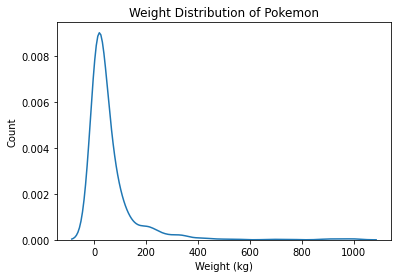

In [14]:
#KDE plot as an example of Weight Distribution on a curve
sns.kdeplot(data['weight_kg'])

plt.title('Weight Distribution of Pokemon')

plt.xlabel('Weight (kg)')
plt.ylabel('Count')

plt.show()

Here we have a KDE (kernel density estimate) with a continuous variable, such as weight.

#### Something like weight could reasonably be expected to correlate with height. ####

In [15]:
#New df with weight and height columns
df = data[['weight_kg', 'height_m']]

In [16]:
df = df.dropna()

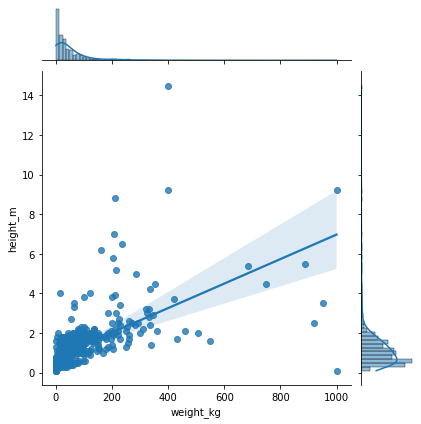

R:  0.6265511437853195 | P-Value: 2.143009087746084e-86


In [17]:
#Create a scatterplot with weight_kg and height_m
g = sns.jointplot(df, x='weight_kg', y='height_m', kind='reg')

#Pearson's R-value (correlation coefficient) and p-value (for statistical significance)
r, p = pearsonr(df['weight_kg'], df['height_m'])

plt.show()
print('R: ', r, '| P-Value:', p)

That's not a particularly interesting finding, but it paves the way for the rest of our exploration.

When you have two variables with a high correlation, you can essentially reduce your variable space to only one of those variables because there would be a redundant effect (on the dependent variables). 

Later on, I will be using PCA for proper dimensionality reduction and to show trends and patterns in the data that would be difficult to see with looking at all the variables at once, that is why this preliminary step of data validation is incredibly important.

- weight_kg

Let's take one more peek at weight. Trying a different view.

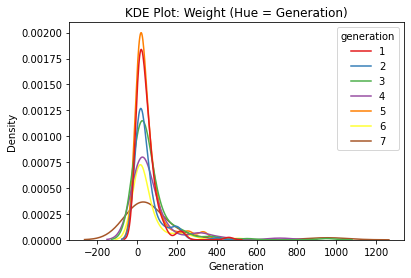

In [18]:
#KDE plot with color indicating generation
sns.kdeplot(data, x='weight_kg', hue='generation', fill=False, palette='Set1')
plt.title('KDE Plot: Weight (Hue = Generation)')
plt.xlabel('Generation')
plt.ylabel('Density')
plt.show()

Here we can see some significant differences between the generations and weight distribution!

#### Maybe taking a look at generations will be interesting in the future. (Hint: it is!) ####

## 3. Forming a Hypothesis ##

We spent some time looking at our columns to see what information has been quantified and qualified about our Pokemon set. 

From those columns we identified two different groupings of interest: the numerical data and the categorical data.

From there, I will conduct two seperate analyses to answer two questions:

#### <u>Qualitative Approach</u>  ####

<strong> 1.  What is the best Pokemon type I could use to fight my opponent's Pokemon? </strong>

For this question, our answer (output) should be a <u>type</u> and our input is the <u>opponent's type.</u>

#### <u>Quantitative Approach - Dimensionality Reduction</u> ####

<strong> 2.  How did the Pokemon designers go about distributing the character's abilities to make the game engaging (perhaps even addicting)?</strong>

This question essentially asks what most data science inquiries look into:
- What are the underlying patterns we can see from the data? 
- What sort of trends can we spot and predict and with what accuracy? 

Frankly, this is the far more interesting question so the majority of the data analysis will focus on: 
- Correlations
- Pearson's R
- P-Values
- Logistic Regressions
- Principal Compopnent Analysis

<strong>Our final goal is to see with what accuracy we can predict a Legendary Pokemon from the least amount of variables.</strong>

## 4. Exploratory Analysis ##

### 1. What is the best Pokemon type I could use to fight my opponent's Pokemon? ###

In [19]:
#How many types are there?
len(set(data.type1))

18

In [20]:
types_columns = ['type1', 'against_bug', 'against_dark', 'against_dragon', 'against_electric',
                    'against_fairy', 'against_fight', 'against_fire', 'against_flying',
                    'against_ghost', 'against_grass', 'against_ground', 'against_ice',
                    'against_normal', 'against_poison', 'against_psychic', 'against_rock',
                    'against_steel', 'against_water']
len(types_columns)

19

In [21]:
#Create a new dataframe (types_df) with just 'type1' and 'against_x'
types_df = data[types_columns]
types_df.shape

(801, 19)

In [22]:
types_df.head()

,type1,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water
0,grass,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5
1,grass,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5
2,grass,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5
3,fire,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0
4,fire,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0


In [23]:
#Group the dataframe by 'type1' and the average score of each type against_x
grouped_df = types_df.groupby('type1').mean()

In [24]:
print(grouped_df.shape)
grouped_df.head()

(18, 18)


,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water
type1,,,,,,,,,,,,,,,,,,
bug,0.826389,0.979167,0.937500,1.138889,0.916667,0.458333,2.194444,2.083333,1.013889,0.420139,0.562500,1.208333,0.930556,0.930556,1.159722,2.291667,0.972222,1.020833
dark,1.724138,0.534483,1.103448,1.103448,2.275862,1.965517,1.034483,1.034483,0.551724,0.775862,0.965517,1.206897,0.931034,0.913793,0.000000,1.241379,1.000000,1.000000
dragon,0.944444,1.037037,2.000000,0.490741,2.111111,0.925926,0.509259,1.055556,1.074074,0.527778,0.925926,2.518519,1.000000,0.925926,1.037037,1.111111,1.000000,0.592593
electric,0.871795,1.000000,0.897436,0.538462,0.948718,1.064103,1.102564,0.474359,0.974359,0.910256,2.051282,1.025641,0.923077,0.935897,0.948718,1.025641,0.500000,1.000000
fairy,0.472222,0.500000,0.000000,1.111111,1.000000,0.472222,1.000000,1.000000,1.000000,0.944444,0.888889,1.111111,1.000000,2.000000,1.000000,1.111111,2.000000,1.000000


Nifty! Grouped_df tells us the averages of each type's values on the against_x scale. 
This gets us started towards our visualization. Let's try a quick function.

In [25]:
#We can find the best opponent by taking the max of the column of the opponent
against_bug_val = grouped_df['against_bug']

In [26]:
against_bug_val.max()

1.7241379310344827

Let's make a prediction algorithm:

In [27]:
#Takes in opponent'type' and predicts strongest 'type' against
def predict_strongest_types(input_type):
    
    against_column = 'against_' + input_type
    against_values = grouped_df[against_column]
    strongest_type = against_values.idxmax()

    return strongest_type

In [28]:
input_type = 'bug'

In [29]:
predicted_types = predict_strongest_types(input_type)
print(predicted_types)

dark


Nice! Let's make that into a dataframe so we can visualize it.

In [30]:
predicted_df = pd.DataFrame(columns=['type_opponent', 'type_predicted_best'])

In [31]:
for column in grouped_df.columns:
    if column.startswith('against_'):

        opponent_type = column.replace('against_', '')
        predicted_best_type = predict_strongest_types(opponent_type)

        predicted_df = predicted_df.append({'type_opponent': opponent_type, \
                                            'type_predicted_best': predicted_best_type},
                                           ignore_index=True)

In [32]:
print(predicted_df.shape)

(18, 2)


In [33]:
predicted_df

,type_opponent,type_predicted_best
0,bug,dark
1,dark,psychic
2,dragon,dragon
3,electric,water
4,fairy,dark
5,fight,rock
6,fire,bug
7,flying,bug
8,ghost,psychic
9,grass,rock


Neat! Let's visualize with the ever-so-popular Sankey Diagrams!

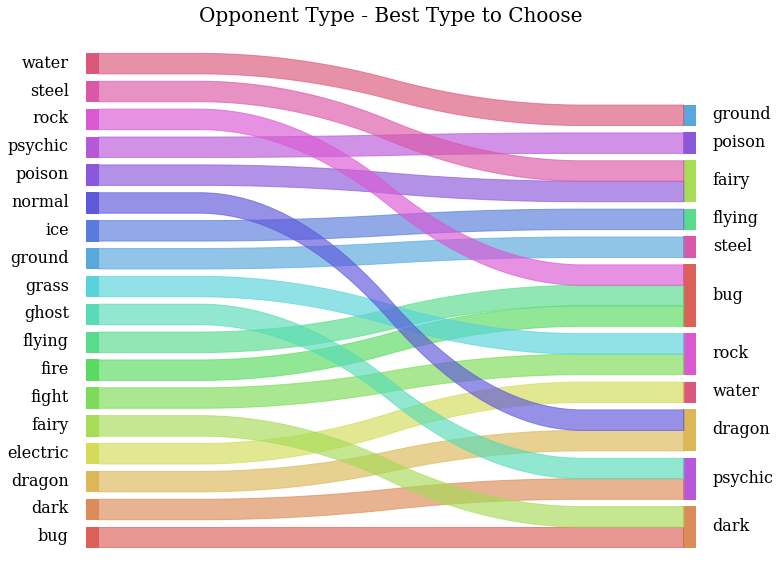

In [34]:
sankey(predicted_df['type_opponent'], predicted_df['type_predicted_best'], fontsize=16)
plt.title('Opponent Type - Best Type to Choose', fontsize=20)
plt.gcf().set_size_inches((12, 10))
plt.show()

So pretty! So cool! So nostalgic! Moving on to a bigger challenge... Dimensionality Reduction.

### 2. What trends can we visualize? ###

We can start by choosing our selected numerical values and then looking at the correlation coefficient matrix for multiple variables.

<strong>Numerical Columns:</strong>
- attack
- base_egg_steps
- base_happiness
- base_total
- capture_rate
- defense
- experience_growth
- height_m
- hp
- percentage_male
- pokedex_number
- sp_attack
- sp_defense
- speed
- weight_kg
- generation
- is_legendary

In [35]:
num_cols = ['attack', 'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
            'defense', 'experience_growth', 'height_m', 'hp', 'percentage_male',
            'pokedex_number', 'sp_attack', 'sp_defense', 'speed', 'type1', 'type2',
            'weight_kg', 'generation', 'is_legendary']

In [36]:
num_df = data[num_cols]
print(num_df.shape)

(801, 19)


In [37]:
num_df.head()

,attack,base_egg_steps,base_happiness,base_total,capture_rate,defense,experience_growth,height_m,hp,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,49,5120,70,318,45,49,1059860,0.7,45,88.1,1,65,65,45,grass,poison,6.9,1,0
1,62,5120,70,405,45,63,1059860,1.0,60,88.1,2,80,80,60,grass,poison,13.0,1,0
2,100,5120,70,625,45,123,1059860,2.0,80,88.1,3,122,120,80,grass,poison,100.0,1,0
3,52,5120,70,309,45,43,1059860,0.6,39,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,64,5120,70,405,45,58,1059860,1.1,58,88.1,5,80,65,80,fire,NaN,19.0,1,0


Let's check out some correlations for more concrete data.

In [38]:
#Assign corr to variable
correlation_matrix = num_df.corr()

In some cases, high correlation between two variables indicates redundancy, implying that both variables provide similar information. In such situations, it might be beneficial to consider removing one of the variables to simplify the analysis or avoid issues related to <b>multicollinearity</b> in regression models.

Acommonly used guideline is that an R value above 0.7 or 0.8 indicates a high correlation between variables. In such cases, it suggests a strong linear relationship, and one of the variables might be redundant or provide redundant information. 

We saw such a relationship between weight and height, but at an R value around 0.6 -- in that particular situation there was a high left skew of the weight distribution which explains why they are not more highly correlated).

#### Strong Correlations R > 0.6 #### 

In [39]:
strong_correlations = correlation_matrix[(correlation_matrix > 0.6) | (correlation_matrix < -0.6)]

In [40]:
strong_correlations = strong_correlations.dropna(how='all')

In [41]:
strong_correlations_df = pd.DataFrame(strong_correlations)

<Axes: >

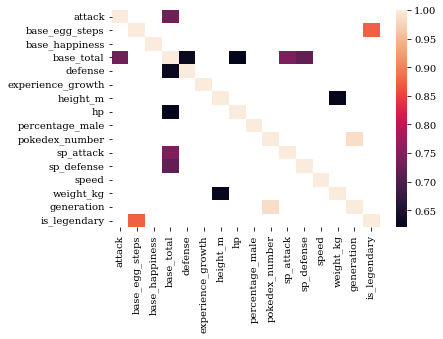

In [42]:
sns.heatmap(strong_correlations_df)

<Axes: title={'center': 'Strong Correlations R > 0.6'}>

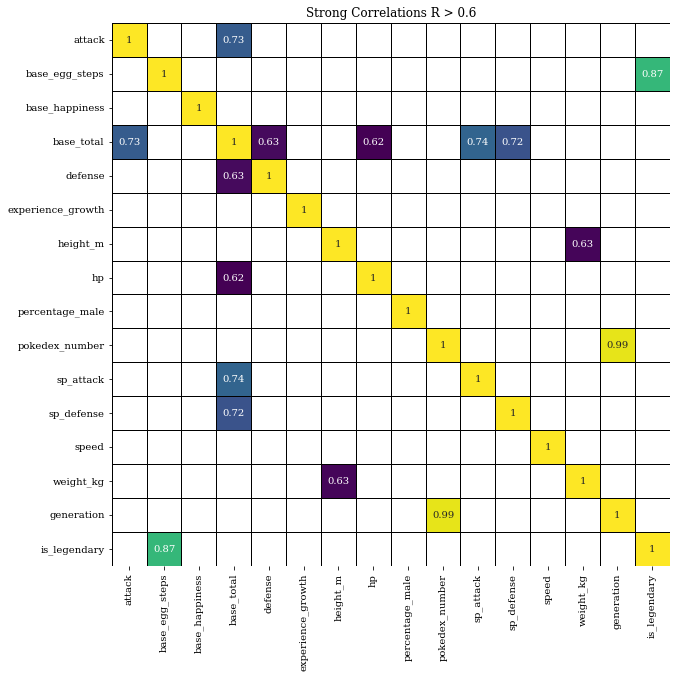

In [43]:
#Add lines and R-Values
plt.figure(figsize=(10, 10))
plt.title('Strong Correlations R > 0.6')
sns.heatmap(strong_correlations_df, annot=True, linecolor='k', linewidths=0.5, cbar=False, cmap='viridis')

<b>Looking to see if base_num is indeed an aggregate measure...<b>

It looks like we can gain some valuable insights with a lower R-cutoff for our heatmap (R > 0.6 rather than R > 0.7)

One obvious trend is that 'base_total' correlates with a few variables. 

As an aggregate measure, that would make sense, considering it is likely the numerical total of the points of some of the columns. 

The Kaggle dataset does not specify exactly, so let's investigate further.

In [44]:
columns_to_check = ['attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'hp']

In [45]:
row_values = data.loc[4, columns_to_check]
base_total_row4 = data.loc[4, 'base_total']

row_values

attack        64
defense       58
sp_attack     80
sp_defense    65
speed         80
hp            58
Name: 4, dtype: object

In [46]:
print('Sum of Values:', row_values.sum())
print('Base Total - Row 4:', base_total_row4)
print('Sum of Values equals Base Total:', row_values.sum() == base_total_row4)

Sum of Values: 405
Base Total - Row 4: 405
Sum of Values equals Base Total: True


Checking all columns...

In [47]:
sum_of_columns = num_df[columns_to_check].sum(axis=1)
is_combination = (sum_of_columns == num_df['base_total']).all()

if is_combination:
    print('base_total is a combination of ' + str(columns_to_check))
else:
    print('base_total is NOT a combination of ' + str(columns_to_check))

base_total is a combination of ['attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'hp']


The aggregate measure is derived from those components. 

Because the components contribute to the calculation of the aggregate measure, it is natural for them to exhibit some level of correlation. 

This finding further affirms that we can use base_total instead of its constituents: attack, defense, sp_attack, sp_defense, speed, hp.

## Correlations ##

<b>Highest Correlations (1.00 > R > 0.8):</b>
- generation and pokedex number
- is_legendary and base_egg_steps

<b>High Correlations (0.8 > R > 0.7):</b>
- base_total and sp_attack
- base_total and sp_defense
- base_total and attack

<b>Strong Correlations (0.7 > R > 0.6):</b>
- base_total and defense
- base_total and hp
- height_m and weight_kg

In [48]:
new_cols = ['attack', 'defense', 'sp_attack', 
            'sp_defense', 'speed', 'hp']

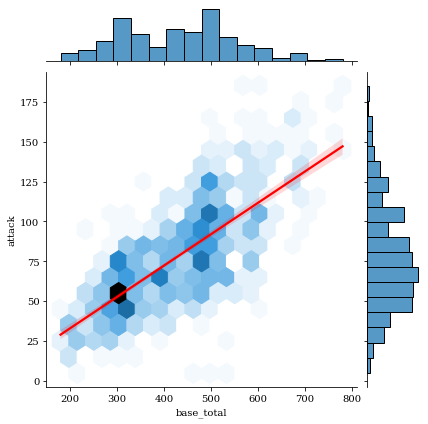

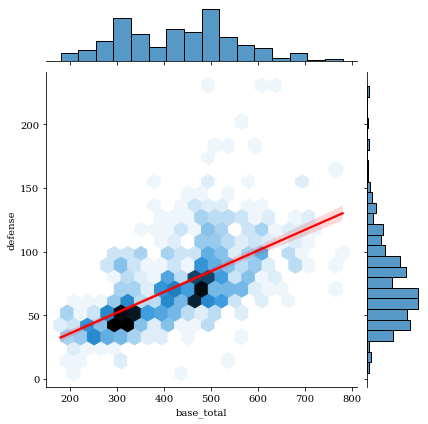

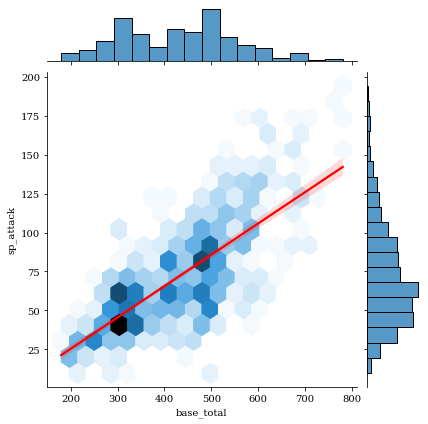

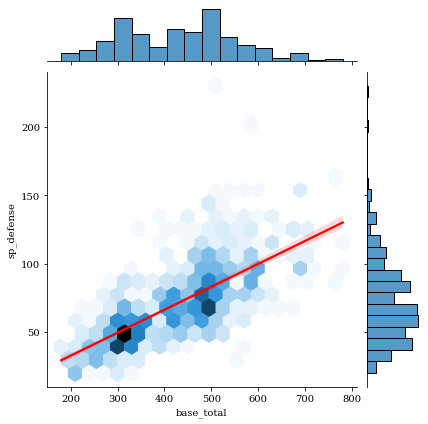

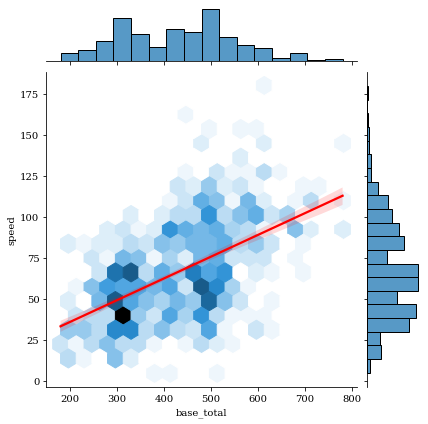

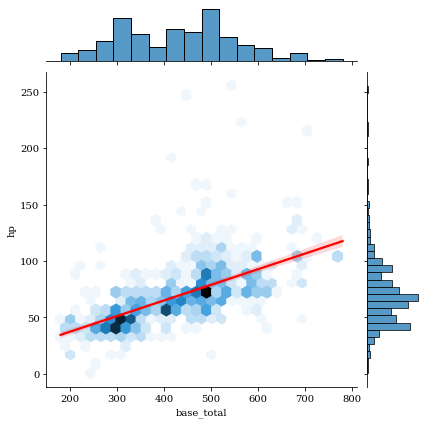

In [49]:
for i in range(len(new_cols)):
    x = 'base_total'
    y = new_cols[i]

    g = sns.jointplot(data=num_df, x=x, y=y, kind='hex')
    
    if not num_df[x].empty:
        sns.regplot(data=num_df, x=x, y=y, scatter=False, ax=g.ax_joint, color='r')

    plt.show()

Regression line in red indicates a positive correlation. Noticable bimodal distribution for base_total.

- generation and pokedex number
- is_legendary and base_egg_steps

### Generation and Pokedex Number ###

This is the most obvious correlation, given that as they added more Pokemon generations, they also added more numbers to the Pokemon Pokedex. 

Here is an illustration of the distribution:

In [50]:
#Pearson's R-value (correlation coefficient) and p-value (for statistical significance)
r, p = pearsonr(data['pokedex_number'], data['generation'])

plt.show()
print('R: ', r, '| P-Value:', p)

R:  0.9859041338189447 | P-Value: 0.0


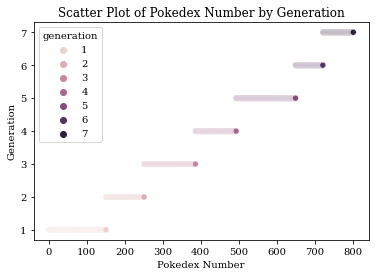

In [51]:
ax = sns.scatterplot(data, x='pokedex_number', y='generation', hue='generation')
ax.set_xlabel('Pokedex Number')
ax.set_ylabel('Generation')
plt.title('Scatter Plot of Pokedex Number by Generation')
plt.show()

### Legendary and Base Steps ###

In [52]:
#Calculate the percentage of legendary Pokemon
num_legendary = data[data['is_legendary'] == 1].shape[0]
percentage = (num_legendary / data.shape[0]) * 100

print('There are ' + str(num_legendary) + ' Legendary Pokemon. The percentage of Legendary Pokemon Overall is ' + str(round(percentage, 2)) + '%')

There are 70 Legendary Pokemon. The percentage of Legendary Pokemon Overall is 8.74%


### Scatterplot of Base Egg Steps Highlighting Legendary Pokemon ###

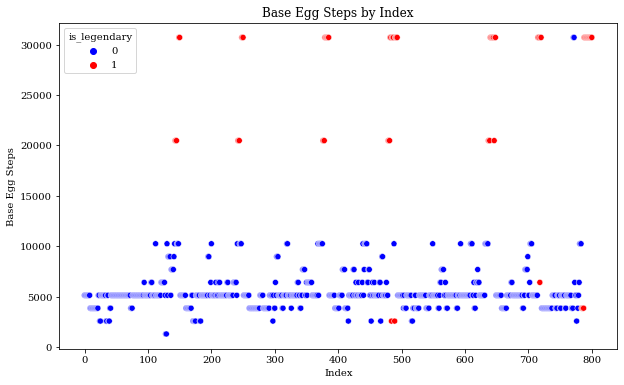

In [53]:
#Hue = Is Legendary
plt.figure(figsize=(10, 6)) 
ax = sns.scatterplot(data, x=data.index, y='base_egg_steps', hue='is_legendary', palette={0: 'blue', 1: 'red'})

ax.set_xlabel('Index')
ax.set_ylabel('Base Egg Steps')
plt.title('Base Egg Steps by Index')

plt.show()

It looks like the game designers reserved the legendary pokemon for those who commit to walking significantly more steps than average...

<b>Making the legendary pokemon attainable only after a higher level of commitment ensures that users continue participating.</b>

The 'base_egg_steps' column provides information about the number of steps needed for the egg of a particular Pokémon species to hatch.

In the Pokémon games, trainers can obtain Pokémon eggs and carry them in their party. 

As trainers walk a certain number of steps, the egg undergoes an incubation process and eventually hatches into a Pokémon. 

It makes sense that more 'legendary' pokemon would be more difficult to acquire, but also that hard work reaps rewards.

In [54]:
#Standard Deviation of Base Egg Steps
data['base_egg_steps'].std()

6558.2204218159295

In [55]:
#Average Base Egg Steps
data['base_egg_steps'].mean()

7191.011235955056

In [56]:
#Calculate how many standard deviations from the mean is 20,000 steps 
(20000 - data['base_egg_steps'].mean()) / data['base_egg_steps'].std()

1.9531195873557141

Approximately 95% of the data fall within two standard deviations of the mean. 
That means that only around 5% of users will reach a legendary Pokemon.

It looks like most legendary pokemon have a base_egg_steps higher than 20,000 -- let's check.

In [57]:
df_base_egg_steps_20k = data[data['base_egg_steps'] > 20000]

In [58]:
df_base_egg_steps_30k = data[data['base_egg_steps'] > 30000]

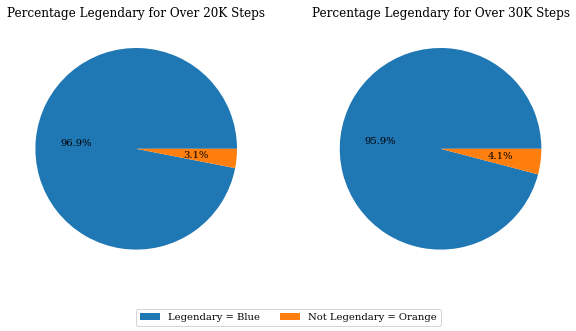

In [59]:
label = ['Legendary = Blue', 'Not Legendary = Orange']

percentage_20k = (df_base_egg_steps_20k[df_base_egg_steps_20k['is_legendary'] == 1].shape[0] / df_base_egg_steps_20k.shape[0]) * 100
percentage_30k = (df_base_egg_steps_30k[df_base_egg_steps_30k['is_legendary'] == 1].shape[0] / df_base_egg_steps_30k.shape[0]) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'top': 0.85, 'bottom': 0.15})

ax1.pie([percentage_20k, 100 - percentage_20k], autopct='%1.1f%%')
ax1.set_title('Percentage Legendary for Over 20K Steps')

ax2.pie([percentage_30k, 100 - percentage_30k], autopct='%1.1f%%')
ax2.set_title('Percentage Legendary for Over 30K Steps')

fig.legend(label, loc='lower center', ncol=2)

plt.show()

In [60]:
print('The percentage of legendary pokemon with a base egg step greater than 20,000 is ' + str(round(percentage_20k, 2)) + '%')
print('The percentage of legendary pokemon with a base egg step greater than 30,000 is ' + str(round(percentage_30k, 2)) + '%')

The percentage of legendary pokemon with a base egg step greater than 20,000 is 96.92%
The percentage of legendary pokemon with a base egg step greater than 30,000 is 95.92%


Amazing! Almost 97% of legendary pokemon require more than 20,000 steps to hatch. 

### What does this mean for our data? ###

- We were able to reduce 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed' and 'hp' to the variable 'base_total'

- We could see that 'base_egg_steps' is clearly correlated with 'is_legendary' so we can safely choose one to focus on (in this case 'is_legendary')

- We were also able to identify that 'pokedex_number' is an index variable, clearly correlating with the 'generation' data (R=0.99), indicating the two variables are interchangable

We can use these three variables in our next part where we do a Principal Component Analysis on the data.

## 5. Final Analysis ##

Text(0.5, 0, 'Base Total')

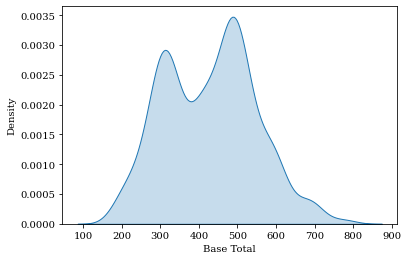

In [61]:
#Simple KDE plot of base_total to look at bimodal distribution
ax = sns.kdeplot(num_df['base_total'], fill=True)
plt.xlabel('Base Total')

Aha! As expected - two peaks. This indicates two 'modes.' Let's look at another type of visualization.

We noticed a trend with weight and generation before, let's see if it is still the case here

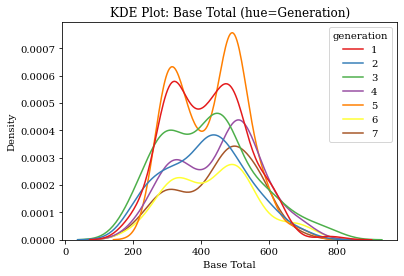

In [62]:
sns.kdeplot(data=num_df, x='base_total', hue='generation', fill=False, palette='Set1')
plt.title('KDE Plot: Base Total (hue=Generation)')
plt.xlabel('Base Total')
plt.ylabel('Density')
plt.show()

It's difficult to see this distribution with a scatterplot. 
We are using Pokedex Numeber because it is random and continuous.

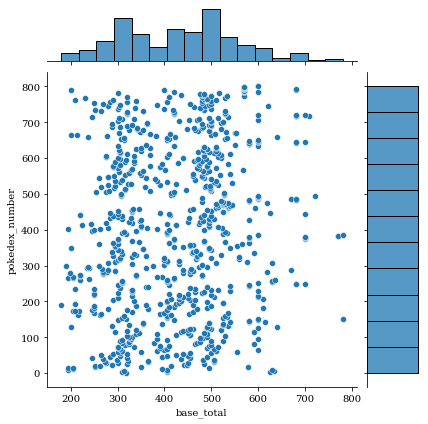

In [63]:
sns.jointplot(num_df, x='base_total', y='pokedex_number')

A pattern is more emergent with a KDE plot.

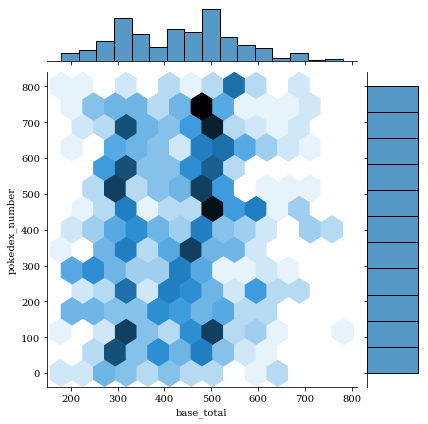

In [64]:
sns.jointplot(num_df, x='base_total', y='pokedex_number', kind='hex')

### This is where things get interesting... ###

Perhaps the distribution can be divided into two groups. There is an above average group and a below average group.

In [65]:
#To simplify, will be using df from now on...
df = num_df

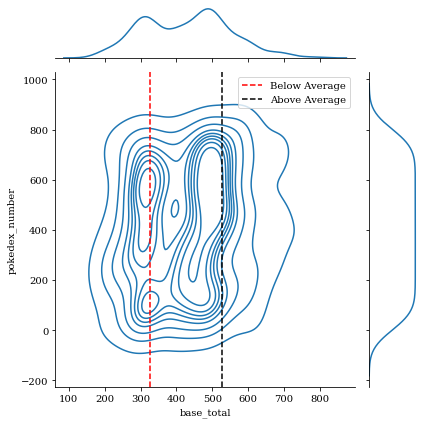

In [66]:
#Split the data into two distributions based on the mean
below_mean = df[df['base_total'] < df['base_total'].mean()]
above_mean = df[df['base_total'] >= df['base_total'].mean()]

#Create a jointplot for the 'base_total' and 'generation' variables
g = sns.jointplot(data=data, x='base_total', y='pokedex_number', kind='kde')

#Add a line to show the mean of each distribution (the below average and above average groupings)
g.ax_joint.axvline(below_mean['base_total'].mean(), color='red', linestyle='--', label='Below Average')
g.ax_joint.axvline(above_mean['base_total'].mean(), color='black', linestyle='--', label='Above Average')

g.ax_joint.legend()

plt.tight_layout()

plt.show()

That's pretty neat! Maybe we can go even further and identify Legendary Pokemon with a color.

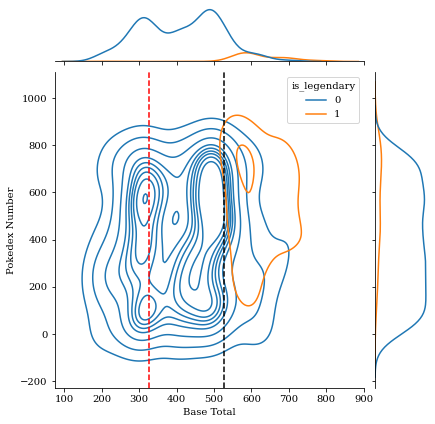

In [67]:
g = sns.jointplot(data=data, x='base_total', y='pokedex_number', kind='kde', hue='is_legendary')
g.ax_joint.axvline(below_mean['base_total'].mean(), color='red', linestyle='--', label='Below Average')
g.ax_joint.axvline(above_mean['base_total'].mean(), color='black', linestyle='--', label='Above Average')

plt.xlabel('Base Total')
plt.ylabel('Pokedex Number')

plt.show()

This graph indicates that the game is set up to have two groups of Pokemon, an above average group and a below average group (denoted by the two higher density groupings around both the below average and above average demarcations).

It looks like the likelihood of getting an above average pokemon is slightly higher than the likelihood of getting a below average pokemon. This assumption is based on the fact that if you were to draw two overlapping bell curves, one for the below-average group and one for the above-average group, it appears that the area under the curve is higher for the above average group. However, the mean of the above average group does not line up with the largest bin of the histogram, so there must be other factors at play or ways to illustrate these relationships.

What further adds to this analysis is the labeling of Legendary pokemon. You can clearly see that the game developers kept the Legendary Pokemon base_total all in the above-average group, approximately one standard deviation above the above-average mean.

<b>From this we can narrow our variables of interest to:</b>
- generation
- pokedex_number
- is_legendary
- base_egg_steps

In [68]:
average = df['base_total'].mean()

Calculate mean and standard deviation of above-average group...

In [69]:
#Split base_total in two to show bimodal distribution
above_average_group = df[df['base_total'] > average]

mean_above = np.mean(above_average_group['base_total'])
std_above = np.std(above_average_group['base_total'])

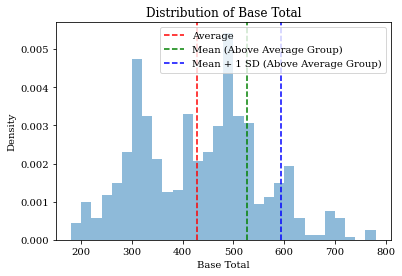

In [70]:
plt.hist(df['base_total'], bins=30, density=True, alpha=0.5)
plt.axvline(x=average, color='red', linestyle='--', label='Average')
plt.axvline(x=mean_above, color='green', linestyle='--', label='Mean (Above Average Group)')
plt.axvline(x=mean_above + std_above, color='blue', linestyle='--', label='Mean + 1 SD (Above Average Group)')

plt.legend()

plt.xlabel('Base Total')
plt.ylabel('Density')
plt.title('Distribution of Base Total')

plt.show()

The above chart shows some of our unexplored hypotheses have potential to be true.

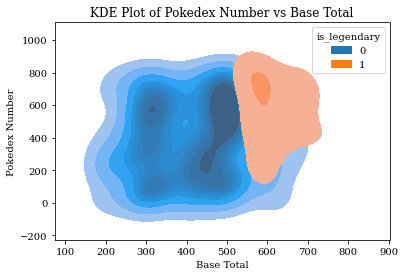

In [71]:
#Same graph as before but filled in for contrast
sns.kdeplot(df, x='base_total', y='pokedex_number', hue='is_legendary', fill=True)

plt.title('KDE Plot of Pokedex Number vs Base Total')

plt.xlabel('Base Total')
plt.ylabel('Pokedex Number')

plt.show()

## PCA (Principle Component Analysis) ##

We can safetly narrow our variables of interest to:
- base_total
- pokedex_number
- is_legendary

These will the 'features' in our PCA 

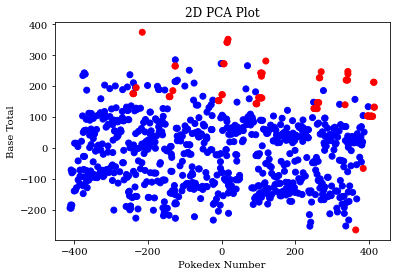

In [72]:
#Load the data
df = pd.read_csv('./pokemon.csv')

#Select the features
features = ['base_total', 'pokedex_number']

#Run PCA
pca = PCA(n_components=2)  
pca.fit(df[features])

#Get the principal components
principal_components = pca.transform(df[features])

#Define colors for each data point
colors = np.where(df['is_legendary'] == 1, 'red', 'blue')

#Plot the 2D PCA plot with customized colors
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=colors)

#Set labels and title
plt.xlabel('Pokedex Number')
plt.ylabel('Base Total')
plt.title('2D PCA Plot')

plt.show()

This plot isn't particularly pretty or informative. We still see . Let's see if a 3D PCA Plot can help.

### 3D PCA and KDE of Base Total ###

We applied PCA to do Dimensionality Reduction and Normalization on our features.

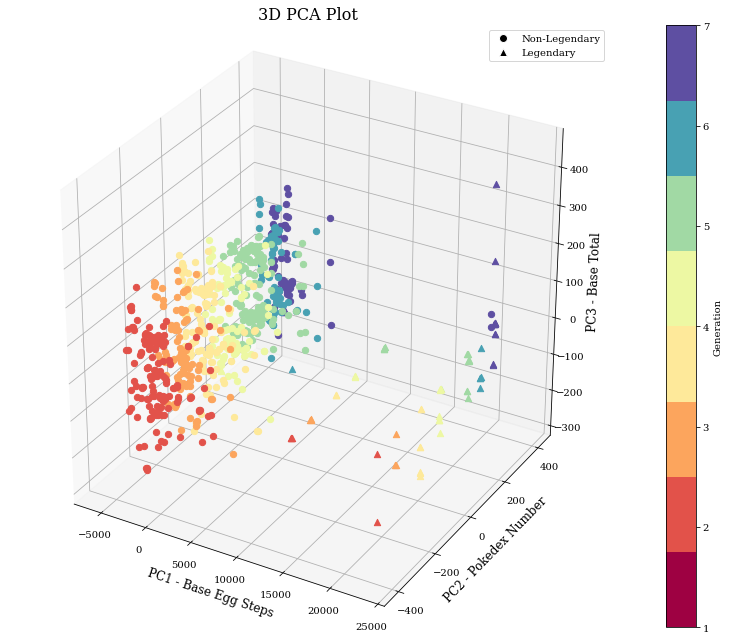

In [73]:
#Loading the data from the top to make sure there are no errors along the way
data = pd.read_csv('pokemon.csv')

#Selecting the features we identified by narrowing down our independent variables
features = ['base_total', 'pokedex_number', 'base_egg_steps']

#Run PCA
pca = PCA(n_components=3)
pca.fit(data[features])

#Get the principal components
principal_components = pca.transform(data[features])

#Define the colormap with a unique color for each generation
colormap = plt.cm.get_cmap('Spectral', 8)

#Define markers for each data point based on the 'is_legendary' column
markers = ['o' if value == 0 else '^' for value in data['is_legendary']]

#Set the figure size (Resolution is 1600 x 900)
plt.figure(figsize=(16, 9))

#Create the 3D plot
ax = plt.axes(projection='3d')

#Set Legendary to triangle markers
for i, marker in enumerate(markers):
    ax.scatter(principal_components[i, 0], principal_components[i, 1], principal_components[i, 2],
               c=colormap(data['generation'][i]), marker=marker, s=40)

#Set labels and title - continuous variable, independent variable
ax.set_xlabel('PC1 - Base Egg Steps', fontsize=12)
ax.set_ylabel('PC2 - Pokedex Number', fontsize=12)
ax.set_zlabel('PC3 - Base Total', fontsize=12)
ax.set_title('3D PCA Plot', fontsize=16)

#Add legend for is_legendary - discrete variable, dependent variable
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Non-Legendary', markerfacecolor='black', markersize=8),
    Line2D([0], [0], marker='^', color='w', label='Legendary', markerfacecolor='black', markersize=8)
]
ax.legend(handles=legend_elements)

#Set the aspect ratio to equal
ax.set_box_aspect([1, 1, 1])

#Adjust the font size of tick labels
ax.tick_params(labelsize=10)

#Set the legend for colormap by generation - discrete variable, independent variable
sm = ScalarMappable(cmap=colormap)
sm.set_array(data['generation'])
cbar = plt.colorbar(sm)
cbar.set_ticks(range(1, 8))
cbar.set_label('Generation')

plt.tight_layout()

# Set x-label and y-label
g.set_axis_labels('Base Egg Steps', 'Generation')

#Set to 100 dpi
plt.savefig('pca_plot.png', dpi=100)

plt.show()

# 6. Discussion and Conclusion #

Assuming you don't have the time to look through all of your Pokemon, a user would want a quick heuristic guide for seeing which Pokemon Type would be the best to choose in any given instance against a particular type of Pokemon.

To best demonstrate this, we created a new dataframe looking solely at 'type1' and the 'against_x' columns.

This resulted in a Sankey Diagram which was easy to read to give us the best pokemon type to defeat our opponent:

### Sankey Diagram ###

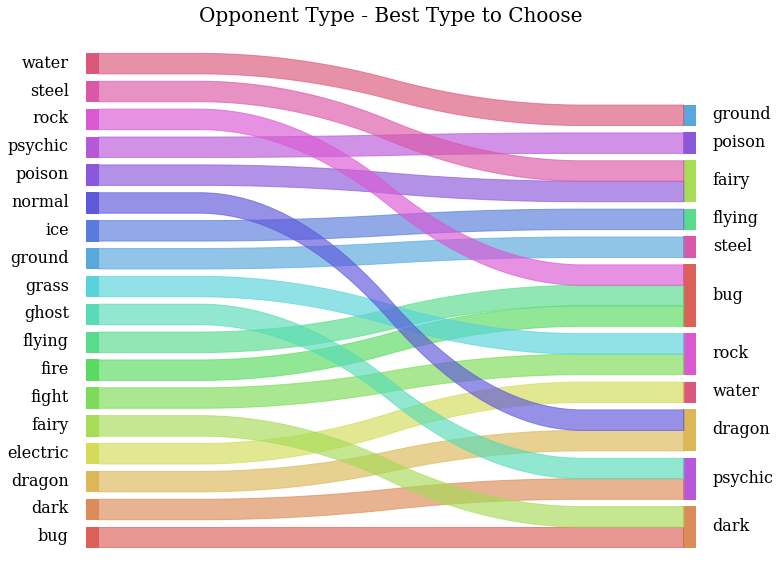

In [74]:
sankey(predicted_df['type_opponent'], predicted_df['type_predicted_best'], fontsize=16)
plt.title('Opponent Type - Best Type to Choose', fontsize=20)
plt.gcf().set_size_inches((12, 10))
plt.show()

The next task was to answer the question:

2.  How did the Pokemon designers go about distributing the character's abilities to make the game engaging (perhaps even addicting)?

### Astonishingly, after so much digging, we finally unravelled some of the secrets of the Pokemon game! ###

### 3D PCA and KDE of Base Total ###

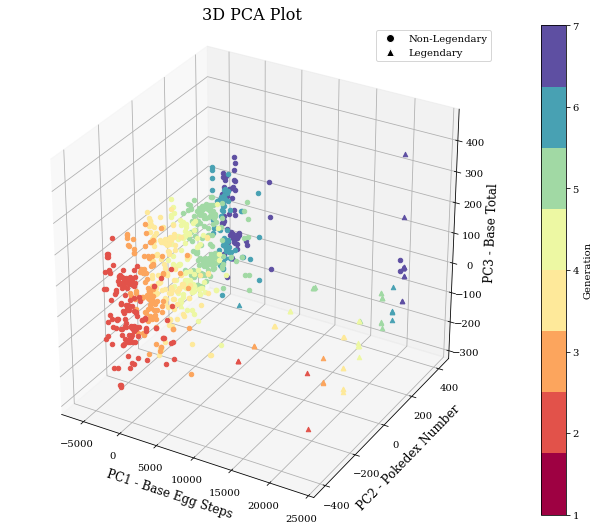

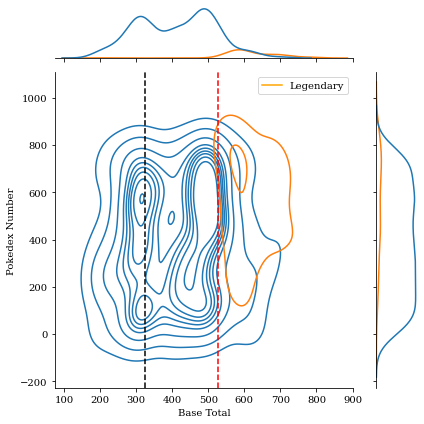

In [75]:
#Loading the data from the top to make sure there are no errors along the way
data = pd.read_csv('./pokemon.csv')

#Selecting the features we identified by narrowing down our independent variables
features = ['base_total', 'pokedex_number', 'base_egg_steps']

#Run PCA
pca = PCA(n_components=3)
pca.fit(data[features])

#Get the principal components
principal_components = pca.transform(data[features])

#Define the colormap with a unique color for each generation
colormap = plt.cm.get_cmap('Spectral', 8)

#Define markers for each data point based on the 'is_legendary' column
markers = ['o' if value == 0 else '^' for value in data['is_legendary']]

#Set the figure size (Resolution is 1600 x 900)
plt.figure(figsize=(16, 9))

#Create the 3D plot
ax = plt.axes(projection='3d')

#Set Legendary to triangle markers
for i, marker in enumerate(markers):
    ax.scatter(principal_components[i, 0], principal_components[i, 1], principal_components[i, 2],
               c=colormap(data['generation'][i]), marker=marker, s=20)

#Set labels and title - continuous variable, independent variable
ax.set_xlabel('PC1 - Base Egg Steps', fontsize=12)
ax.set_ylabel('PC2 - Pokedex Number', fontsize=12)
ax.set_zlabel('PC3 - Base Total', fontsize=12)
ax.set_title('3D PCA Plot', fontsize=16)

#Add legend for is_legendary - discrete variable, dependent variable
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Non-Legendary', markerfacecolor='black', markersize=8),
    Line2D([0], [0], marker='^', color='w', label='Legendary', markerfacecolor='black', markersize=8)
]
ax.legend(handles=legend_elements)

#Set the aspect ratio to equal
ax.set_box_aspect([1, 1, 1])

#Adjust the font size of tick labels
ax.tick_params(labelsize=10)

#Set the legend for colormap by generation - discrete variable, independent variable
sm = ScalarMappable(cmap=colormap)
sm.set_array(data['generation'])
cbar = plt.colorbar(sm)
cbar.set_ticks(range(1, 8))
cbar.set_label('Generation')

#Split the data into two distributions based on the mean
below_mean = data[data['base_total'] < data['base_total'].mean()]
above_mean = data[data['base_total'] >= data['base_total'].mean()]

#Create a jointplot for the 'base_total' and 'generation' variables
g = sns.jointplot(data=data, x='base_total', y='pokedex_number', kind='kde', hue='is_legendary')

#Add a line to show the mean of each distribution (the below average and above average groupings)
g.ax_joint.axvline(below_mean['base_total'].mean(), color='black', linestyle='--', label='Below Average')
g.ax_joint.axvline(above_mean['base_total'].mean(), color='red', linestyle='--', label='Above Average')

#Display the legend for the second graph
g.ax_joint.legend(['Below Average', 'Above Average'])

#Add a separate legend for the second graph to denote 'Legendary' with orange color
legend_elements2 = [
    Line2D([0], [0], color='orange', label='Legendary')
]
g.ax_joint.legend(handles=legend_elements2, loc='upper right')

g.ax_joint.add_artist(legend_elements[0])
g.ax_joint.add_artist(legend_elements[1])

#Set x-label and y-label
g.set_axis_labels('Base Total', 'Pokedex Number')

plt.tight_layout()

plt.show()

## Conclusion ##

It is clear that there is a bimodal distribution of Base Total.

Legendary Pokemon are defined by the number is Base Egg Steps and Base Total.

Furthermore, generation colors show that legendary pokemon is NOT concentrated in any particular generation and spread throughout the Pokedex.

## Discussion ##

The PCA and KDE shows clearly that Legendary pokemon are in a league of their own. Not only are they all centered in the above average portion of the KDE, they also primarily consist of the majority of Pokemon that 20,000 steps or more and have a high base total. The Pokedex Scale shows that there is a relatively similar distribution of Legendary pokemon per generation, evenly distributed across the Pokedex numbers.

#### How does this affect player strategy / incentives? ####

There is a near 50-50 chance of either getting an above average or below average pokemon which is estimated by a similar area under the KDE curve. This could makes someone continue to play (aka 'flip the proverbial coin') since their odds aren't particularly bad. 

Of course, the above average pokemon are not entirely distributed around the mean of the above-average group, but rather a bit below. This ensures that other factors such as strategy or dedication can lend itself toward giving weaker players an upper hand over time. 

As someone continues playing, the chances of getting a significantly better Pokemon (a legendary one) increase because there is a strong correlation between Base Egg Steps and Legendary Pokemon (R = 0.87). 

In fact, your likelihood of getting a Legendary Pokemon shifts to a 96% chance after 20,000 steps.


Players could easily become addicted to such favorable odds, considering that the number of Base Egg Steps that could likely guarentee someone a Legenary is only about 2 standard deviations from the mean. That means that 5% of users will likely get at least one Legendary Pokemon.

With a Base Total that is completely above average, these Legendary Pokemon are powerful and can likely beat most opponents based on stats alone.

With a look at our Type vs Type Sankey Diagram, we can see which Pokemon type has, on average across all Pokemon with that specific type, the best likelihood of beating your opponent's type. Thus, all other stats being equal, some attacks may be more effective than others depending on the Pokemon type. This supplementary data can help a user make an informed decision regarding which Pokemon to choose from their repeitoire.

## Bonus Question: Can we predict a legendary pokemon? With what accuracy? ##

We will be using Linear Regression to predict whether a Pokemon is legendary

In [76]:
#Split data into two parts
legendaryPokemon = df.loc[df['is_legendary'] == 1]
normalPokemon = df.loc[df['is_legendary'] == 0]

#Use same features as before
features = ['base_total', 'pokedex_number', 'base_egg_steps']

#Randomly sample non-legendary Pokémon to balance the dataset
sampledNormalPokemon = normalPokemon.sample(len(legendaryPokemon))

#Concatenate legendary and sampled non-legendary Pokémon
dataset = pd.concat([legendaryPokemon, sampledNormalPokemon])

#Split the dataset into training and testing sets
x = dataset[features]
y = dataset['is_legendary']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [77]:
#Create an instance of the Logistic Regression classifier
classifier = LogisticRegression()

#Fit the classifier to the training data
classifier.fit(x_train, y_train)

#Predict the labels for the test data
y_pred = classifier.predict(x_test)

#Evaluate the performance of the classifier
accuracy = classifier.score(x_test, y_test)
print('Accuracy: ', accuracy)

Accuracy:  0.9642857142857143


### Modeling Our Prediction Accuracy ###

In [78]:
#Prediction Dataframe
preds_df = pd.DataFrame({'is_legendary': y_test, 'is_legendary_pred': y_pred})

In [79]:
preds_df.head()

,is_legendary,is_legendary_pred
197,0,0
798,1,1
490,1,1
155,0,0
644,1,1


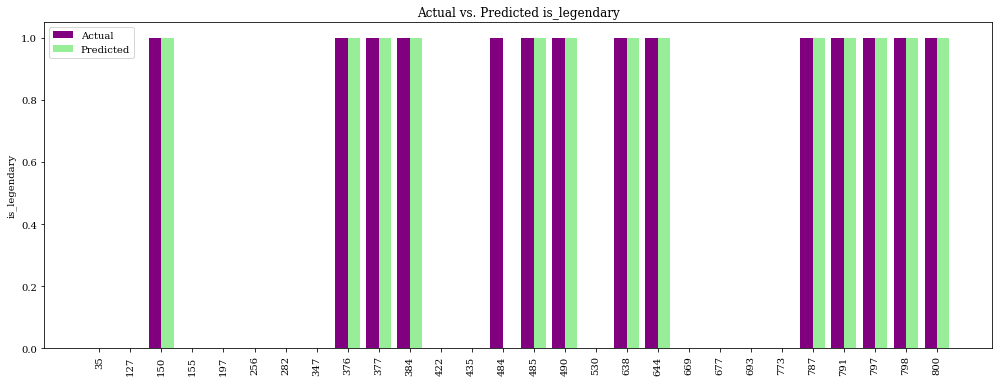

In [80]:
#Sort the DataFrame by index
accuracy_df = preds_df.sort_index()

#Getting the number of data points
N = len(accuracy_df)

#Set the bar width
width = 0.4

#Create the figure and axes
fig, ax = plt.subplots(figsize=(17, 6))

#Define the array of indices
ind = np.arange(N)

#Plot the actual values as a bar chart
ax.bar(ind, accuracy_df['is_legendary'], width, label='Actual', color='#800080')

#Plot the predicted values as a bar chart
ax.bar(ind + width, accuracy_df['is_legendary_pred'], width, label='Predicted', color='#98ee98')

#Set the title and axis labels
ax.set_title('Actual vs. Predicted is_legendary')
ax.set_ylabel('is_legendary')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(accuracy_df.index)
plt.xticks(rotation=90)

#Display the legend
plt.legend()

#Show the plot
plt.show()

Adding more samples to our data...

In [81]:
df.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


In [82]:
df_test = df[features]

In [83]:
df_test.head()

,base_total,pokedex_number,base_egg_steps
0,318,1,5120
1,405,2,5120
2,625,3,5120
3,309,4,5120
4,405,5,5120


In [84]:
#Apply PCA to the feature data of df_test
x_test_pca = pca.transform(df_test)

In [85]:
#Predict the labels for the PCA-transformed df_test data
y_pred_test = classifier.predict(x_test_pca)

In [86]:
#Merge df_test and preds_df_test on 'pokedex_number'
df_test = pd.merge(df_test, df[['pokedex_number', 'is_legendary']], on='pokedex_number', how='left')

#Show updated df_test
df_test

,base_total,pokedex_number,base_egg_steps,is_legendary
0,318,1,5120,0
1,405,2,5120,0
2,625,3,5120,0
3,309,4,5120,0
4,405,5,5120,0
...,...,...,...,...
796,570,797,30720,1
797,570,798,30720,1
798,570,799,30720,1
799,600,800,30720,1


In [87]:
#New df with df_test and Predicted values
preds_df_test = pd.DataFrame({'is_legendary': df_test['is_legendary'], 'is_legendary_pred': y_pred_test})

Accuracy: 92.0%


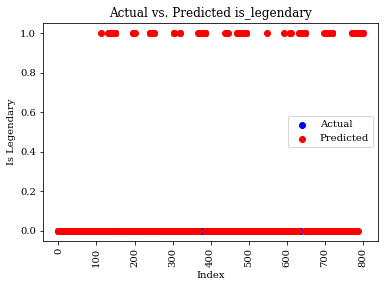

In [88]:
#Calculate the accuracy
accuracy = (preds_df_test['is_legendary'] == preds_df_test['is_legendary_pred']).mean()

#Create the scatter plot
plt.scatter(preds_df_test.index, preds_df_test['is_legendary'], label='Actual', color='blue')
plt.scatter(preds_df_test.index, preds_df_test['is_legendary_pred'], label='Predicted', color='red')

plt.title('Actual vs. Predicted is_legendary')
plt.xlabel('Index')
plt.ylabel('Is Legendary')
plt.xticks(rotation=90)
plt.legend()

#Add a text annotation for accuracy
print('Accuracy: ' + str(round(accuracy, 3) * 100) + '%')

plt.show()

### That's a really high accuracy from only three features! ###

Thank you for reaching my research on the Pokemon dataset!

Thank you to Angel Hack for the opportunity to work on this exciting data and showcase my skills with data analysis using Python, Seaborn, PCA, Linear Regression Classifiers and Jupyter Notebook. Also, thank you to Rohan Patil and Kaggle for the dataset. (https://www.kaggle.com/rohanpatil63)

### Notebook written by: Diana Ciuca | dianaciu.ca | dianaciuca@gmail.com ###